In [1]:
import os
from IPython.display import display
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

scaler = StandardScaler()

pd.set_option('display.max_columns', 100)

%reload_ext autoreload
%autoreload 2

In [2]:
df_for_clustering = pd.read_csv('data_clustering.csv')

In [29]:
df_for_clustering = df_for_clustering[['customer_id', 'hour', 'category', 
                                       'week_period', 'months_interval']]

df_for_clustering.head()

,customer_id,hour,category,week_period,months_interval
0,0000366f3b9a7992bf8c76cfdf3221e2,10,furniture,week,19
1,0000b849f77a49e4a4ce2b2a4ca5be3f,11,health_beauty,week,19
2,0000f46a3911fa3c0805444483337064,21,supplies,week,5
3,0000f6ccb0745a6a4b88665a16c9f078,20,electronics,week,12
4,0004aac84e0df4da2b147fca70cf8255,19,electronics,week,13


In [32]:
data = df_for_clustering[['customer_id','hour']].copy()
data = data.groupby('customer_id').median()

df_tmp = df_for_clustering[['customer_id']].copy()
df_tmp['nb_achats'] = 1
df_tmp = df_tmp.groupby('customer_id').sum()
data = data.join(df_tmp)

df = df_for_clustering.set_index('customer_id')[['category',
                                                 'week_period']].copy()
for col in df.columns:
    df_ohe = pd.get_dummies(df[col])
    df_ohe.reset_index(inplace = True)
    df_ohe = df_ohe.groupby('customer_id').sum()
    for c in df_ohe.columns:
        df_ohe[c] /= data.nb_achats
    data = data.join(df_ohe)

data.drop(columns = 'nb_achats', inplace = True)
data.head()

,hour,construction,electronics,fashion,food_drink,furniture,gifts,health_beauty,home,misc,sports_leisure,supplies,unknown,week,week-end
customer_id,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0000f46a3911fa3c0805444483337064,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0004aac84e0df4da2b147fca70cf8255,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
data_test = data.drop(columns = [col for col in data.columns if 'last' in col])

In [28]:
# data utilisée pour le clustering
data_test

,hour,construction,electronics,fashion,food_drink,furniture,gifts,health_beauty,home,misc,sports_leisure,supplies,unknown,week,week-end
customer_id,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0000f46a3911fa3c0805444483337064,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0004aac84e0df4da2b147fca70cf8255,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ffff371b4d645b6ecea244b27531430a,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [33]:
df = data.copy()
data_sc = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index = df.index)

data_sc

,hour,construction,electronics,fashion,food_drink,furniture,gifts,health_beauty,home,misc,sports_leisure,supplies,unknown,week,week-end
customer_id,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.903377,-0.242233,-0.424846,-0.156337,-0.099869,2.159393,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.714565,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,2.383436,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025
0000f46a3911fa3c0805444483337064,1.173550,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,3.512186,-0.121228,0.549025,-0.549025
0000f6ccb0745a6a4b88665a16c9f078,0.984738,-0.242233,2.368634,-0.156337,-0.099869,-0.467617,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025
0004aac84e0df4da2b147fca70cf8255,0.795927,-0.242233,2.368634,-0.156337,-0.099869,-0.467617,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1.173550,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,2.383436,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025
fffea47cd6d3cc0a88bd621562a9d061,0.984738,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,2.383436,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,-1.839293,1.839293
ffff371b4d645b6ecea244b27531430a,0.040681,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,3.512186,-0.121228,0.549025,-0.549025


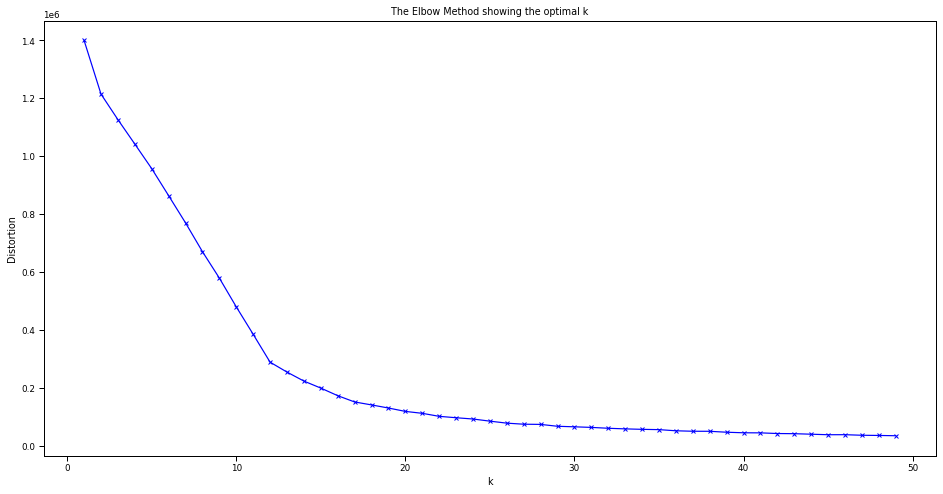

In [34]:
from sklearn.cluster import KMeans

df = data_sc.copy()

distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=2)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('resultats/elbow1.png',bbox_inches='tight')
plt.show()

In [12]:
df_clusters = data_sc.copy()

kmeanModel = KMeans(n_clusters=12, random_state=2)
kmeanModel.fit(scaler.fit_transform(df_clusters))
df_clusters['cluster'] = kmeanModel.predict(df_clusters)

df_clusters

,hour,construction,electronics,fashion,food_drink,furniture,gifts,health_beauty,home,misc,sports_leisure,supplies,unknown,week,week-end,cluster
customer_id,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.903377,-0.242233,-0.424846,-0.156337,-0.099869,2.159393,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025,3
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.714565,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,2.383436,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025,2
0000f46a3911fa3c0805444483337064,1.173550,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,3.512186,-0.121228,0.549025,-0.549025,0
0000f6ccb0745a6a4b88665a16c9f078,0.984738,-0.242233,2.368634,-0.156337,-0.099869,-0.467617,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025,1
0004aac84e0df4da2b147fca70cf8255,0.795927,-0.242233,2.368634,-0.156337,-0.099869,-0.467617,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1.173550,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,2.383436,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,0.549025,-0.549025,2
fffea47cd6d3cc0a88bd621562a9d061,0.984738,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,2.383436,-0.361882,-0.164041,-0.410994,-0.286758,-0.121228,-1.839293,1.839293,2
ffff371b4d645b6ecea244b27531430a,0.040681,-0.242233,-0.424846,-0.156337,-0.099869,-0.467617,-0.246784,-0.422664,-0.361882,-0.164041,-0.410994,3.512186,-0.121228,0.549025,-0.549025,0


In [13]:
cluster_cols = np.argmax(kmeanModel.cluster_centers_,axis=1)
print('Features ayant le plus contribué à la création des clusters:')
[x[1] for x in list(enumerate(df_clusters.columns)) if x[0] in cluster_cols]

Features ayant le plus contribué à la création des clusters:


['construction',
 'electronics',
 'fashion',
 'food_drink',
 'furniture',
 'gifts',
 'health_beauty',
 'home',
 'misc',
 'sports_leisure',
 'supplies',
 'unknown']

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
df = data_sc.copy()

pca = PCA(n_components = df.shape[1], svd_solver = 'auto')
Principal_components = pca.fit_transform(df)
pca_df = pd.DataFrame(data = Principal_components, columns = ['PC'+str(k+1) for k in range(pca.n_components)], index = df.index)
# jointure à effectuer après pour que la colonne cluster ne soit pas
# prise en compte dans nos résultats
pca_df = pca_df.join(df_clusters[['cluster']])

In [15]:
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Cumulative Prop. Variance Explained:  [0.13368238 0.21411933 0.29272875 0.37079734 0.44673114 0.51970177
 0.59093411 0.66160519 0.73036863 0.79868696 0.86643223 0.9338029
 1.         1.         1.        ]


In [16]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,cluster
customer_id,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.775922,2.270086,0.145124,-0.169380,-0.374374,-0.359290,-0.181476,-0.135838,-0.024470,-0.034628,0.079253,0.056631,0.939019,-3.213027e-14,-9.840806e-16,3
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.848396,-0.772334,-1.859218,-1.325177,-0.689686,-0.489751,-0.220753,-0.089181,-0.086165,-0.043970,0.031402,0.017504,0.677623,1.942037e-13,-1.897412e-15,2
0000f46a3911fa3c0805444483337064,-0.756200,-0.092524,-0.085464,0.089257,0.488390,3.055314,-1.898292,-0.064279,-0.545944,-0.088373,-0.288682,-0.177375,-1.091495,6.857790e-13,3.429598e-16,0
0000f6ccb0745a6a4b88665a16c9f078,-0.746117,-0.825350,1.999550,-0.932046,-0.618837,-0.410872,-0.170749,0.112009,-0.269704,-0.028987,-0.224783,-0.147663,-1.146219,1.508358e-13,1.966663e-16,1
0004aac84e0df4da2b147fca70cf8255,-0.758325,-0.835029,2.007848,-0.932492,-0.621626,-0.417616,-0.176049,0.092146,-0.251321,-0.029892,-0.199242,-0.131128,-0.962922,7.264022e-14,5.345745e-16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,-0.726309,-0.675542,-1.942197,-1.320713,-0.661796,-0.422315,-0.167756,0.109447,-0.270004,-0.034917,-0.224007,-0.147843,-1.155342,-1.093899e-17,1.032432e-16,2
fffea47cd6d3cc0a88bd621562a9d061,2.629897,-0.786615,-1.920229,-1.327777,-0.714102,-0.399452,-0.222879,0.070829,-0.244707,-0.031568,-0.171728,-0.093434,-0.764629,-4.822081e-17,1.714175e-17,2
ffff371b4d645b6ecea244b27531430a,-0.829452,-0.150599,-0.035677,0.086578,0.471656,3.014852,-1.930091,-0.183455,-0.435641,-0.093805,-0.135437,-0.078166,0.008284,-6.083501e-17,5.854596e-17,0


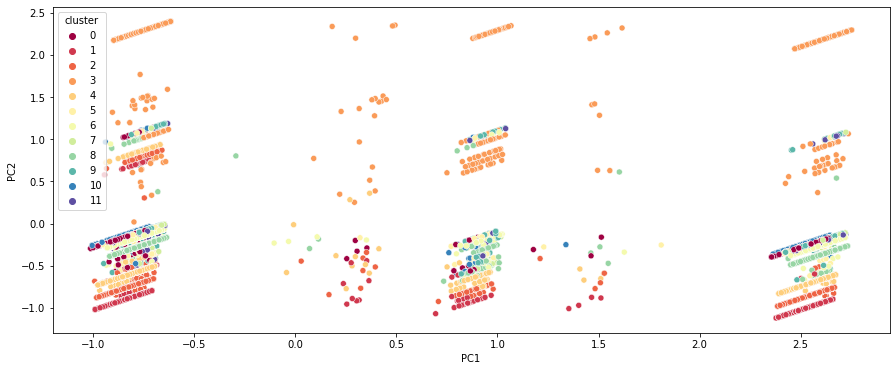

In [17]:
plt.figure(figsize=(15,6))
sns.scatterplot(data = pca_df,
                x = 'PC1',
                y = 'PC2',
                hue = 'cluster', 
                legend = 'full',
                palette = sns.color_palette("Spectral", as_cmap=True))
plt.show()

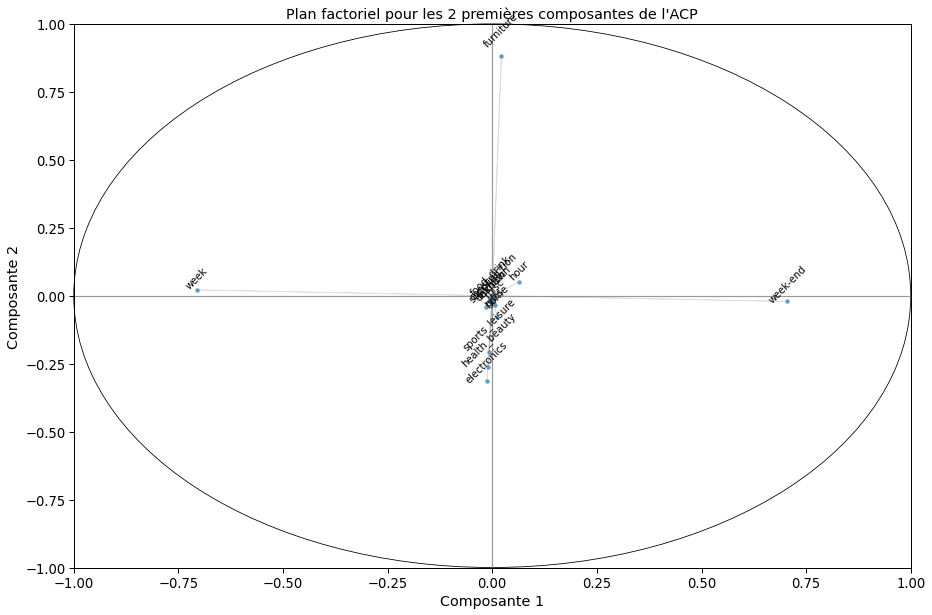

In [18]:
from matplotlib.patches import Circle
sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(15,10))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
ax = plt.gca()
ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', 
                    clip_on=False))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
x_pca = pca.components_[0,:]
y_pca = pca.components_[1,:]

sns.scatterplot(x = x_pca,
                y = y_pca,
               alpha = 0.7)
plt.plot([-1,1],[0,0], color='grey', alpha=0.8)
plt.plot([0,0],[-1,1], color='grey', alpha=0.8)

i = 0
for x,y,colonne in zip(x_pca,y_pca, df.columns):

    plt.annotate(colonne, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,5+np.random.randint(-10,10)),
                 ha='center',
                rotation=45,
                fontsize=10) 
    ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey',
             alpha=0.2)


sns.set_context("paper", font_scale=1)

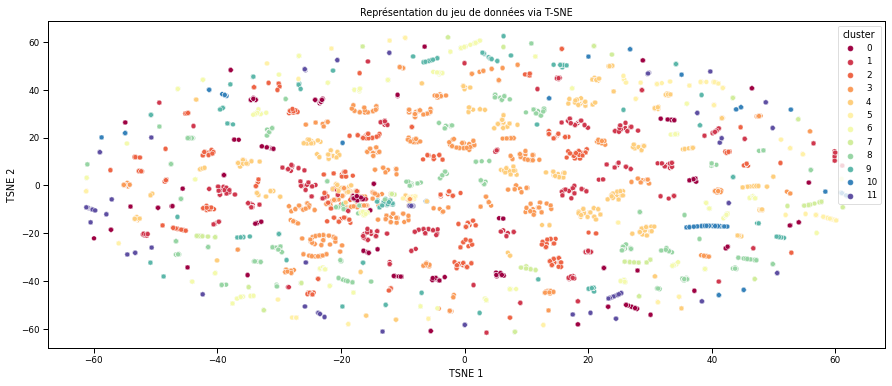

In [19]:
from sklearn.manifold import TSNE

df = data_sc.copy()
tsne = TSNE(n_components=2)
# P_c pour ne pas prendre en compte la colonne cluster
T = tsne.fit_transform(Principal_components.copy())
tsne_df = pd.DataFrame(data = T, columns = ['TSNE '+str(k+1) for k in range(T.shape[1])], index = df.index)
tsne_df = tsne_df.join(df_clusters[['cluster']])

plt.figure(figsize=(15,6))
plt.title('Représentation du jeu de données via T-SNE')
sns.scatterplot(data = tsne_df,
                x = 'TSNE 1',
                y = 'TSNE 2',
                hue = 'cluster', 
                legend = 'full',
                palette = sns.color_palette("Spectral", as_cmap=True))
plt.show()

Analyse de sensibilité

In [37]:
data_0_12 = df_for_clustering[df_for_clustering.months_interval < 12].copy().drop(columns = ['months_interval']).reset_index()
data_3_15 = df_for_clustering[(df_for_clustering.months_interval >= 3) & (df_for_clustering.months_interval < 15)].copy().drop(columns = ['months_interval']).reset_index()
data_6_18 = df_for_clustering[(df_for_clustering.months_interval >= 6) & (df_for_clustering.months_interval < 18)].copy().drop(columns = ['months_interval']).reset_index()
data_9_21 = df_for_clustering[(df_for_clustering.months_interval >= 9) & (df_for_clustering.months_interval < 21)].copy().drop(columns = ['months_interval']).reset_index()
data_12_24 = df_for_clustering[df_for_clustering.months_interval >= 12].copy().drop(columns = ['months_interval']).reset_index()

In [38]:
dfs = [data_0_12.copy(), data_3_15.copy(), data_6_18.copy(), 
       data_9_21.copy(), data_12_24.copy()]

In [39]:
for df,i in zip(dfs,range(len(dfs))):
    data_tmp = df[['customer_id','hour']].copy()
    data_tmp = data_tmp.groupby('customer_id').median()

    df_tmp = df[['customer_id']].copy()
    df_tmp['nb_achats'] = 1
    df_tmp = df_tmp.groupby('customer_id').sum()
    data_tmp = data_tmp.join(df_tmp)

    df_tmp = df.set_index('customer_id')[['category',
                                          'week_period']].copy()
    for col in df_tmp.columns:
        df_ohe = pd.get_dummies(df_tmp[col])
        df_ohe.reset_index(inplace = True)
        df_ohe = df_ohe.groupby('customer_id').sum()
        for c in df_ohe.columns:
            df_ohe[c] /= data_tmp.nb_achats
        data_tmp = data_tmp.join(df_ohe)

    data_tmp.drop(columns = 'nb_achats', inplace = True)
    dfs[i] = data_tmp
    
dfs_sc = [pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index = df.index) for df in dfs]

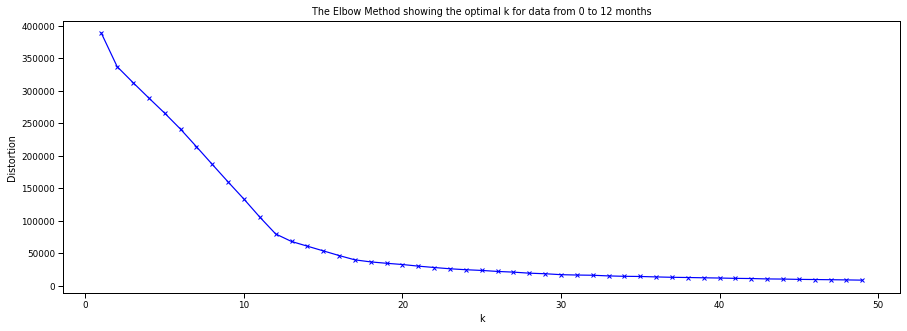

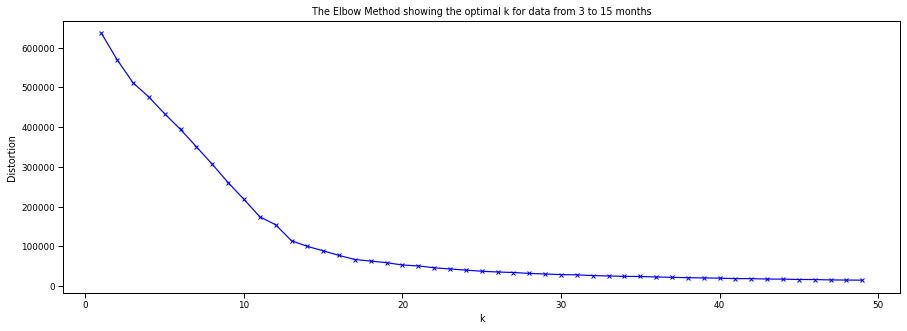

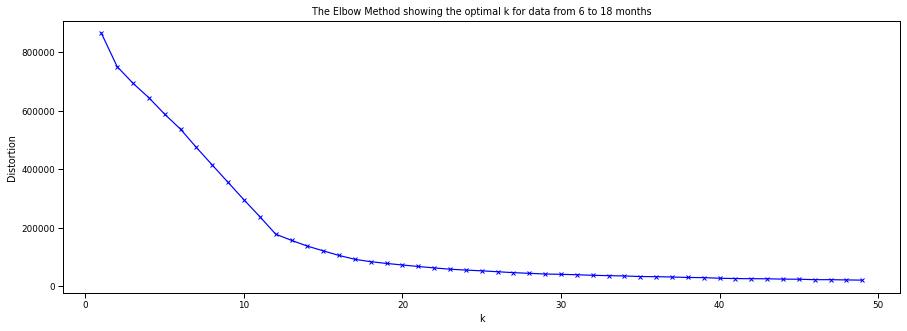

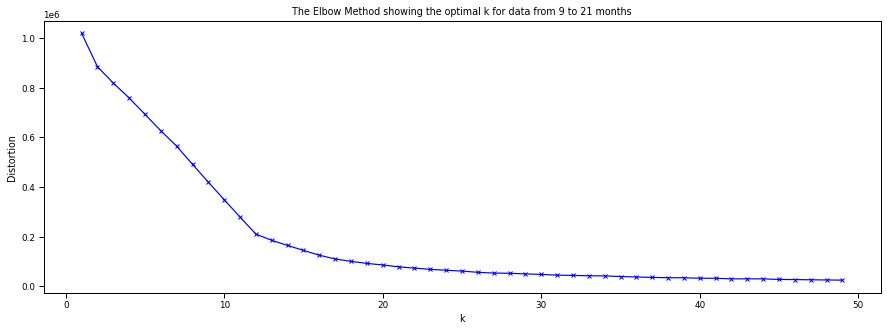

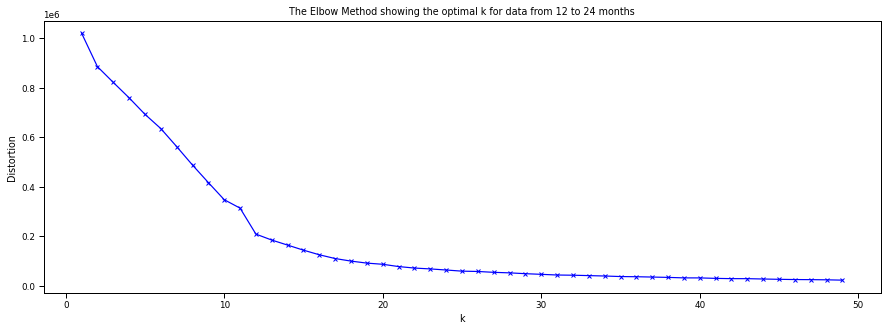

In [24]:
period = 0
for df_sc in dfs_sc:
    distortions = []
    K = range(1,50)
    for k in K:
        kmeanModel = KMeans(n_clusters=k,random_state=2)
        kmeanModel.fit(df_sc)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(15,5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k for data from ' + str(period) + ' to ' + str(period+12) + ' months')
    period += 3
    plt.show()

In [41]:
dfs_clusters = []
models = []
nb_clusters = [12, 13, 12, 12, 12] 

for df_sc,n in zip(dfs_sc,nb_clusters):
    df_tmp = df_sc.copy()
    kmeanModel = KMeans(n_clusters=n, random_state=2)
    kmeanModel.fit(scaler.fit_transform(df_tmp))
    models.append(kmeanModel)
    dfs_clusters.append(df_tmp)

period = 0    

for df_c,model in zip(dfs_clusters,models):
    cluster_cols = np.argmax(model.cluster_centers_,axis=1)
    L = [x[1] for x in list(enumerate(df_c.columns)) if x[0] in cluster_cols]
    print('Features ayant le plus participé à la création des clusters pour la période de ' + str(period) + ' à ' + str(period+12) + ' mois:\n')
    print(L,'\n\n')
    period+=3
    
for df_c, model in zip(dfs_clusters, models):
    df_c['cluster'] = model.predict(df_c)+1
    df_c.cluster = df_c.cluster.astype(int)
    
clusters_only = [df_c[['cluster']].rename(columns = {'cluster' : 'cluster for period '+str(i+1)}) for (df_c, i) in zip(dfs_clusters, range(len(dfs_clusters)))]

Features ayant le plus participé à la création des clusters pour la période de 0 à 12 mois:

['construction', 'electronics', 'fashion', 'food_drink', 'furniture', 'gifts', 'health_beauty', 'home', 'misc', 'sports_leisure', 'supplies', 'unknown'] 


Features ayant le plus participé à la création des clusters pour la période de 3 à 15 mois:

['construction', 'electronics', 'fashion', 'food_drink', 'furniture', 'gifts', 'health_beauty', 'home', 'misc', 'sports_leisure', 'supplies', 'unknown'] 


Features ayant le plus participé à la création des clusters pour la période de 6 à 18 mois:

['construction', 'electronics', 'fashion', 'food_drink', 'furniture', 'gifts', 'health_beauty', 'home', 'misc', 'sports_leisure', 'supplies', 'unknown'] 


Features ayant le plus participé à la création des clusters pour la période de 9 à 21 mois:

['construction', 'electronics', 'fashion', 'food_drink', 'furniture', 'gifts', 'health_beauty', 'home', 'misc', 'sports_leisure', 'supplies', 'unknown'] 


Feat

In [26]:
all_scores = []
for (df_i, i) in zip(clusters_only, range(len(clusters_only))):
    rand_scores = []
    for (df_j, j) in zip(clusters_only, range(len(clusters_only))):
        if i == j:
            rand_scores.append(1.)
        else:
            df = df_i.copy()
            df = df.join(df_j).dropna().astype(int)
            rand_scores.append(adjusted_rand_score(df.values.T[0], df.values.T[1]))
    all_scores.append(rand_scores)

names = ['period '+str(i+1) for i in range(len(clusters_only))]

df = pd.DataFrame(index=names, columns=names, data=all_scores)
df.columns.name = 'rand score'
df

rand score,period 1,period 2,period 3,period 4,period 5
period 1,1.000000,0.916081,0.978458,0.944386,0.073784
period 2,0.916081,1.000000,0.925498,0.912435,0.893065
period 3,0.978458,0.925498,1.000000,0.988732,0.977576
period 4,0.944386,0.912435,0.988732,1.000000,0.991978
period 5,0.073784,0.893065,0.977576,0.991978,1.000000


In [27]:
# Intersection de tous les clients sur toutes les périodes

df = clusters_only[0].copy()
for df_c in clusters_only[1:]:
    df = df.join(df_c)

df = df.dropna().astype(int)

display(df)

all_scores = []

for i in range(len(df.columns)):
    all_scores.append([adjusted_rand_score(df.values.T[i], df.values.T[j]) for j in range(len(df.columns))])

all_scores

names = ['period '+str(i+1) for i in range(len(df.columns))]
df = pd.DataFrame(index=names,columns=names,data=all_scores)
df.columns.name = 'rand score'
df

,cluster for period 1,cluster for period 2,cluster for period 3,cluster for period 4,cluster for period 5
customer_id,,,,,
004288347e5e88a27ded2bb23747066c,5,3,3,7,6
011b4adcd54683b480c4d841250a987f,2,2,10,12,8
012452d40dafae4df401bced74cdb490,4,13,5,4,5
01c289bb06354cdc7e6549570f20ada4,10,9,11,11,10
01f2285f85a1c603eb7ef755ad311769,2,2,4,6,1
...,...,...,...,...,...
f96be73d5c1d3bfe8fcba7924798ba91,1,1,6,4,5
fd09c64a101e3eff4adbca1b28552514,8,11,9,9,1
fd47af963b760f05fbc357474509905e,1,1,6,4,5


rand score,period 1,period 2,period 3,period 4,period 5
period 1,1.000000,0.668160,0.475641,0.262857,0.080348
period 2,0.668160,1.000000,0.489930,0.304082,0.144748
period 3,0.475641,0.489930,1.000000,0.617668,0.322228
period 4,0.262857,0.304082,0.617668,1.000000,0.556869
period 5,0.080348,0.144748,0.322228,0.556869,1.000000
